# 가구특성과 배달매출(금액,종류)와의 상관관계 찾기 
# => 최적의 구/동 선정

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import re
from sklearn.preprocessing import minmax_scale
import warnings
warnings.filterwarnings("ignore")

## 1. 1인 가구와 배달 매출액 k-means 클러스터링

In [2]:
# 배달매출 데이터 읽기
delivery_raw=pd.read_csv("delivery_seoul.csv",dtype={'배달목적지 주소 법정동 리명': object })

In [3]:
delivery_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791041 entries, 0 to 791040
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         791041 non-null  int64  
 1   순번                 791041 non-null  int64  
 2   처리일시               791041 non-null  object 
 3   배달요청업체 ID          791041 non-null  object 
 4   배달요청상태값            791041 non-null  int64  
 5   배달접수회사 ID          782328 non-null  object 
 6   배달상점ID             791041 non-null  object 
 7   배달상점 업종이름          791041 non-null  object 
 8   배달상점 주소 법정동코드      791041 non-null  int64  
 9   배달상점 주소 법정동 시도명    791041 non-null  object 
 10  배달상점 주소 법정동 시군구명   791041 non-null  object 
 11  배달상점 주소 법정동 읍면동명   791041 non-null  object 
 12  배달상점 주소 법정동 리명     0 non-null       float64
 13  배달상점 주소 행정동 코드     791041 non-null  int64  
 14  배달상점주소 도로명주소 코드    778226 non-null  float64
 15  배달목적지 주소 법정동코드     784725 non-null  float64
 16  배달

In [4]:
# 요약본 
delivery=delivery_raw[['처리일시','배달상점 업종이름','배달상점 주소 법정동 시군구명','배달상점 주소 법정동 읍면동명','배달목적지 주소 법정동 시군구명','배달목적지 주소 법정동 읍면동명','배달상품금액','배달비용','배달접수시간','배달완료시간']]

In [5]:
delivery.head()

,처리일시,배달상점 업종이름,배달상점 주소 법정동 시군구명,배달상점 주소 법정동 읍면동명,배달목적지 주소 법정동 시군구명,배달목적지 주소 법정동 읍면동명,배달상품금액,배달비용,배달접수시간,배달완료시간
0,2020-01-01,치킨,은평구,갈현동,은평구,갈현동,23000,3300,2020-01-01 00:01:14,2020-01-01 00:18:47
1,2020-01-01,분식,구로구,오류동,구로구,궁동,28000,3800,2020-01-01 01:27:00,2020-01-01 01:41:45
2,2020-01-01,치킨,영등포구,대림동,영등포구,신길동,17000,4800,2020-01-01 00:51:49,2020-01-01 01:23:41
3,2020-01-01,치킨,영등포구,신길동,영등포구,대림동,19000,3900,2020-01-01 00:02:53,2020-01-01 00:42:53
4,2020-01-01,치킨,금천구,독산동,관악구,신림동,21000,4300,2020-01-01 01:27:08,2020-01-01 01:37:01


In [6]:
delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791041 entries, 0 to 791040
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   처리일시               791041 non-null  object
 1   배달상점 업종이름          791041 non-null  object
 2   배달상점 주소 법정동 시군구명   791041 non-null  object
 3   배달상점 주소 법정동 읍면동명   791041 non-null  object
 4   배달목적지 주소 법정동 시군구명  784725 non-null  object
 5   배달목적지 주소 법정동 읍면동명  784725 non-null  object
 6   배달상품금액             791041 non-null  int64 
 7   배달비용               791041 non-null  int64 
 8   배달접수시간             791041 non-null  object
 9   배달완료시간             777965 non-null  object
dtypes: int64(2), object(8)
memory usage: 60.4+ MB


In [7]:
# 처리일시 컬럼 날짜데이터로 변환
delivery.loc[:,"처리일시"]=pd.to_datetime(delivery["처리일시"])

In [8]:
#시간만 분리해 저장
delivery.loc[:,"배달접수시간"]=delivery['배달접수시간'].str[-8:].map(lambda x:x.replace(':',''))
delivery.loc[:,"배달접수시간"]=delivery['배달접수시간'].str[0:2]
delivery.loc[:,"배달접수시간"]=delivery['배달접수시간'].astype(int)

In [9]:
# 동 개수 : 133개
delivery['배달목적지 주소 법정동 읍면동명'].value_counts()

개봉동    67718
독산동    52998
오류동    52230
시흥동    45232
구로동    44374
       ...  
춘의동        1
동산동        1
상동         1
구기동        1
양평동        1
Name: 배달목적지 주소 법정동 읍면동명, Length: 133, dtype: int64

In [10]:
# 컬럼이름 재설정
delivery=delivery.rename(columns={'배달상점 주소 법정동 시군구명':'구',
                                  '배달상점 주소 법정동 읍면동명':'동',
                                  '배달목적지 주소 법정동 시군구명':'목적지구',
                                  '배달목적지 주소 법정동 읍면동명':'목적지동',
                                  '배달상품금액':'금액',
                                 '배달상점 업종이름':'업종',
                                 '배달접수시간':'접수시간',
                                 '배달완료시간':'완료시간'})

In [11]:
#2019년 서울시 가구원수 분석(공공데이터포털  http://data.seoul.go.kr/dataList/10996/S/2/datasetView.do;jsessionid=2FEB6CF10570193FF74235EAC107123B.new_portal-svr-11)
member_gu_raw=pd.read_csv("2019_seoul_members.txt",sep=None,encoding="UTF-8")

In [12]:
member_gu=member_gu_raw.drop(index=[0,1])

In [13]:
member_gu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 2 to 26
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   기간           25 non-null     object
 1   구분           25 non-null     object
 2   일반가구수        25 non-null     object
 3   가구원수별 가구수    25 non-null     object
 4   가구원수별 가구수.1  25 non-null     object
 5   가구원수별 가구수.2  25 non-null     object
 6   가구원수별 가구수.3  25 non-null     object
 7   가구원수별 가구수.4  25 non-null     object
 8   가구원수별 가구수.5  25 non-null     object
 9   가구원수별 가구수.6  25 non-null     object
 10  평균가구원수       25 non-null     object
dtypes: object(11)
memory usage: 2.3+ KB


In [14]:
member_gu.head()

,기간,구분,일반가구수,가구원수별 가구수,가구원수별 가구수.1,가구원수별 가구수.2,가구원수별 가구수.3,가구원수별 가구수.4,가구원수별 가구수.5,가구원수별 가구수.6,평균가구원수
2,2019,종로구,"62,652","24,671","16,208","11,154","7,828","2,143",505,143,2.2
3,2019,중구,"54,496","22,078","14,578","9,540","6,292","1,533",373,102,2.1
4,2019,용산구,"93,177","35,148","25,164","17,439","11,736","2,907",612,171,2.2
5,2019,성동구,"122,770","41,488","32,125","25,634","18,379","4,014",877,253,2.3
6,2019,광진구,"149,905","58,714","35,678","28,054","21,454","4,711","1,006",288,2.2


In [15]:
# 컬럼이름 재설정
member_gu=member_gu.rename(columns={'구분':'구',
                                    '일반가구수':'총계',
                                  '가구원수별 가구수':'1인가구',
                                  '가구원수별 가구수.1':'2인가구',
                                  '가구원수별 가구수.2':'3인가구',
                                  '가구원수별 가구수.3':'4인가구',
                                 '가구원수별 가구수.4':'5인가구',
                                 '가구원수별 가구수.5':'6인가구',
                                 '가구원수별 가구수.6':'7인가구이상'})

In [16]:
#데이터전처리
member_gu.loc[:,'기간']=member_gu['기간'].astype(int)
member_gu.loc[:,'1인가구']=member_gu['1인가구'].map(lambda x:x.replace(',','')).astype(int)
member_gu.loc[:,'2인가구']=member_gu['2인가구'].map(lambda x:x.replace(',','')).astype(int)
member_gu.loc[:,'3인가구']=member_gu['3인가구'].map(lambda x:x.replace(',','')).astype(int)
member_gu.loc[:,'4인가구']=member_gu['4인가구'].map(lambda x:x.replace(',','')).astype(int)
member_gu.loc[:,'5인가구']=member_gu['5인가구'].map(lambda x:x.replace(',','')).astype(int)
member_gu.loc[:,'6인가구']=member_gu['6인가구'].map(lambda x:x.replace(',','')).astype(int)
member_gu.loc[:,'7인가구이상']=member_gu['7인가구이상'].map(lambda x:x.replace(',','')).astype(int)
member_gu.loc[:,'총계']=member_gu['총계'].map(lambda x:x.replace(',','')).astype(int)

In [24]:
data1=delivery.groupby(delivery['구'],as_index=False).sum()
data1.head()

,구,금액,배달비용,접수시간
0,관악구,476420240,89139580,438812
1,구로구,6525882983,1061655550,4933587
2,금천구,3252498354,539191760,2350830
3,노원구,326081209,61982650,269385
4,도봉구,1911215011,278548800,1294096


In [25]:
df1=pd.merge(data1,member_gu,how='inner')

In [26]:
df1=df1.rename(columns={'금액':'총주문금액'})

In [27]:
#데이터 정규화
df1['1인가구']=minmax_scale(df1['1인가구'])
df1['총주문금액']=minmax_scale(df1['총주문금액'])
df1['배달비용']=minmax_scale(df1['배달비용'])
df1['총계']=minmax_scale(df1['총계'])

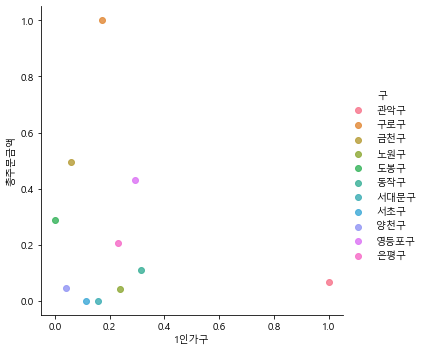

In [28]:
# 1인가구수와 총주문금액을 서울시 구별로 분류
sns.lmplot('1인가구','총주문금액',data=df1,hue='구')

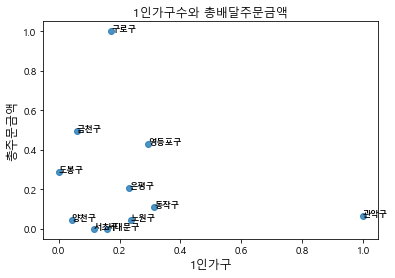

In [29]:
# 1인가구수와 총주문금액을 서울시 구별로 분류
p1=sns.regplot(x =df1['1인가구'],y=df1['총주문금액'],fit_reg=False)

for line in range(0,len(df1)):
     p1.text(df1["1인가구"][line], df1["총주문금액"][line],df1["구"][line], horizontalalignment='left', size='small', color='black', weight='semibold')
        
plt.xlabel('1인가구', fontsize=12)
plt.ylabel('총주문금액', fontsize=12)
plt.title('1인가구수와 총배달주문금액', fontsize=12)
plt.show()

In [30]:
#k-means
X = df1[["구", "총주문금액"]]
X = pd.get_dummies(X)

In [31]:
kmeans=KMeans(n_clusters=3).fit(X)
df1['클러스터']=kmeans.labels_

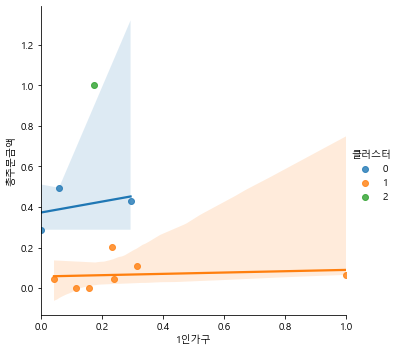

In [32]:
# 1인가구수와 총주문금액을 k-means 분석으로 분류
sns.lmplot('1인가구','총주문금액',data=df1,hue='클러스터')

In [33]:
# 1인가구 수 대비 배달총금액이 가장 큰 구
df1[df1['클러스터']==2]

,구,총주문금액,배달비용,접수시간,기간,총계,1인가구,2인가구,3인가구,4인가구,5인가구,6인가구,7인가구이상,평균가구원수,클러스터
1,구로구,1.0,1.0,4933587,2019,0.427495,0.172996,43700,34624,26459,6214,1261,380,2.4,2


## 2. 1인 가구와 배달 매출액 k-means 클러스터링(동별)

In [34]:
# 동별 가구원수 데이터 읽기
member_dong_raw=pd.read_csv("2015_동별가구원수.txt",sep="\t")

In [35]:
member_dong=member_dong_raw.drop(index=0)

In [36]:
member_dong=member_dong[member_dong['동']!='소계']

In [37]:
member_dong.head()

,기간,자치구,동,계,1인가구,2인가구,3인가구,4인가구,5인가구,6인가구,7인이상 가구
2,2015,종로구,사직동,"3,562","1,125","1,006",731,500,145,40,15
3,2015,종로구,삼청동,"1,092",363,296,214,151,45,14,9
4,2015,종로구,부암동,"3,841",995,"1,082",836,660,190,53,25
5,2015,종로구,평창동,"6,310","1,252","1,709","1,573","1,248",388,105,35
6,2015,종로구,무악동,"2,823",508,698,734,692,153,29,9


In [38]:
member_dong.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 2 to 449
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   기간       424 non-null    int64 
 1   자치구      424 non-null    object
 2   동        424 non-null    object
 3   계        424 non-null    object
 4   1인가구     424 non-null    object
 5   2인가구     424 non-null    object
 6   3인가구     424 non-null    object
 7   4인가구     424 non-null    object
 8   5인가구     424 non-null    object
 9   6인가구     424 non-null    object
 10  7인이상 가구  424 non-null    object
dtypes: int64(1), object(10)
memory usage: 39.8+ KB


In [39]:
member_dong.loc[:,'1인가구']=member_dong['1인가구'].map(lambda x:x.replace(',','')).astype(int)
member_dong.loc[:,'계']=member_dong['계'].map(lambda x:x.replace(',','')).astype(int)

In [40]:
data2=delivery.groupby(delivery['동'],as_index=False).sum()

In [41]:
p = re.compile("[^0-9]")

In [42]:
data2['동'][15]

'당산동4가'

In [43]:
"".join(p.findall(data2['동'][1]))

'가산동'

In [44]:
data2['동']=data2['동'].map(lambda x:"".join(p.findall(x)))
member_dong['동']=member_dong['동'].map(lambda x:"".join(p.findall(x)))

In [45]:
df2=pd.merge(data2,member_dong,how='inner')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 108
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   동        109 non-null    object
 1   금액       109 non-null    int64 
 2   배달비용     109 non-null    int64 
 3   접수시간     109 non-null    int32 
 4   기간       109 non-null    int64 
 5   자치구      109 non-null    object
 6   계        109 non-null    int32 
 7   1인가구     109 non-null    int32 
 8   2인가구     109 non-null    object
 9   3인가구     109 non-null    object
 10  4인가구     109 non-null    object
 11  5인가구     109 non-null    object
 12  6인가구     109 non-null    object
 13  7인이상 가구  109 non-null    object
dtypes: int32(3), int64(3), object(8)
memory usage: 11.5+ KB


In [46]:
df2=df2.rename(columns={'금액':'배달금액합계'})
df2

,동,배달금액합계,배달비용,접수시간,기간,자치구,계,1인가구,2인가구,3인가구,4인가구,5인가구,6인가구,7인이상 가구
0,가리봉동,30132090,5040650,23899,2015,구로구,5029,2303,"1,337",748,468,127,35,11
1,가산동,316580499,43953820,195304,2015,금천구,10348,6116,"1,866","1,215",865,218,55,13
2,갈현동,1044388500,152766230,707153,2015,은평구,9527,2438,"2,701","2,195","1,674",406,80,33
3,갈현동,1044388500,152766230,707153,2015,은평구,10620,2322,"2,888","2,580","2,104",555,134,37
4,개봉동,2936957418,460976580,2186675,2015,구로구,11657,1961,"3,054","3,091","2,633",684,184,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,창동,685594100,99067600,465110,2015,도봉구,10946,2219,"2,931","2,768","2,291",550,136,51
105,창동,685594100,99067600,465110,2015,도봉구,6037,1695,"1,597","1,319","1,091",265,54,16
106,창동,685594100,99067600,465110,2015,도봉구,9887,1656,"2,397","2,552","2,588",548,124,22
107,창동,685594100,99067600,465110,2015,도봉구,9171,1585,"2,347","2,463","2,177",464,103,32


In [47]:
df2=df2.groupby(df2['동'],as_index=False).sum()
df2

,동,배달금액합계,배달비용,접수시간,기간,계,1인가구
0,가리봉동,30132090,5040650,23899,2015,5029,2303
1,가산동,316580499,43953820,195304,2015,10348,6116
2,갈현동,2088777000,305532460,1414306,4030,20147,4760
3,개봉동,8810872254,1382929740,6560025,6045,32081,6377
4,고척동,2396475866,417144940,1870640,4030,19723,4504
5,공릉동,60879000,13805000,59264,4030,32106,9687
6,구로동,3992861215,656213150,2834000,10075,54921,19168
7,구산동,12591300,1298060,6444,2015,10861,1845
8,남가좌동,87896300,20027800,79954,4030,12720,4413
9,남현동,364900,63000,298,2015,7705,2917


In [48]:
#데이터 정규화
df2['1인가구']=minmax_scale(df2['1인가구'])
df2['배달금액합계']=minmax_scale(df2['배달금액합계'])
df2['배달비용']=minmax_scale(df2['배달비용'])
df2['계']=minmax_scale(df2['계'])

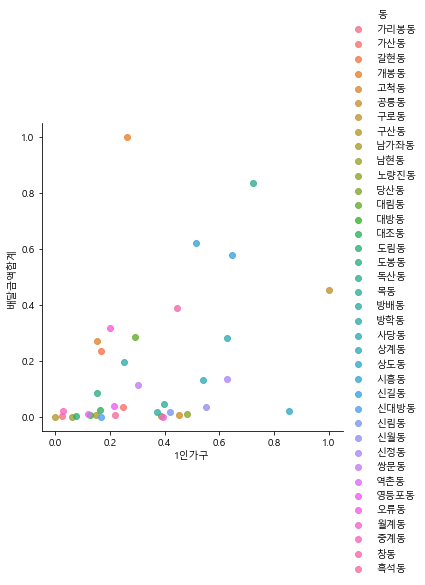

In [49]:
# 1인가구수와 총주문금액을 동별로 분류
sns.lmplot('1인가구','배달금액합계',data=df2,hue='동')

In [50]:
# 1인가구수와 총주문금액을 k-means 분석으로 분류
X = df2[['1인가구','배달금액합계']]
X = pd.get_dummies(X)
kmeans=KMeans(n_clusters=4).fit(X)

In [51]:
df2['클러스터']=kmeans.labels_

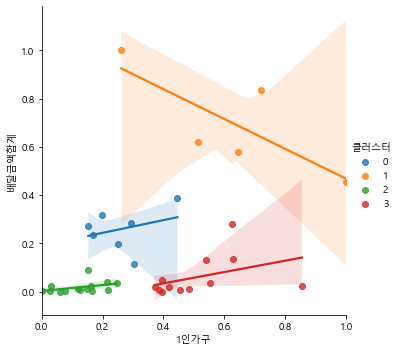

In [52]:
sns.lmplot('1인가구','배달금액합계',data=df2,hue='클러스터')

In [53]:
# 1인가구 수 대비 배달총금액이 가장 큰 동
df2[df2['클러스터']==0] #구로구 개봉동 금천구 독산동

,동,배달금액합계,배달비용,접수시간,기간,계,1인가구,클러스터
2,갈현동,0.237055,0.220911,1414306,4030,0.257231,0.168273,0
4,고척동,0.271979,0.301620,1870640,4030,0.250017,0.153495,0
12,대림동,0.286241,0.302574,1788315,6045,0.291840,0.292501,0
20,방학동,0.199057,0.195863,1237140,6045,0.418056,0.251284,0
30,쌍문동,0.113952,0.082184,557960,8060,0.423144,0.303700,0
33,오류동,0.319476,0.330487,2173718,4030,0.315950,0.198349,0
36,창동,0.389051,0.358163,2325550,10075,0.700231,0.445708,0


## 3. 총 가구수와 배달 매출액 k-means 클러스터링(동별)

In [54]:
df2

,동,배달금액합계,배달비용,접수시간,기간,계,1인가구,클러스터
0,가리봉동,0.003403,0.003619,23899,2015,0.000000,0.026439,2
1,가산동,0.035914,0.031758,195304,2015,0.090502,0.246551,2
2,갈현동,0.237055,0.220911,1414306,4030,0.257231,0.168273,0
3,개봉동,1.000000,1.000000,6560025,6045,0.460287,0.261618,1
4,고척동,0.271979,0.301620,1870640,4030,0.250017,0.153495,0
5,공릉동,0.006893,0.009956,59264,4030,0.460713,0.452693,3
6,구로동,0.453165,0.474496,2834000,10075,0.848908,1.000000,1
7,구산동,0.001412,0.000912,6444,2015,0.099231,0.000000,2
8,남가좌동,0.009959,0.014456,79954,4030,0.130862,0.148242,2
9,남현동,0.000025,0.000019,298,2015,0.045532,0.061883,2


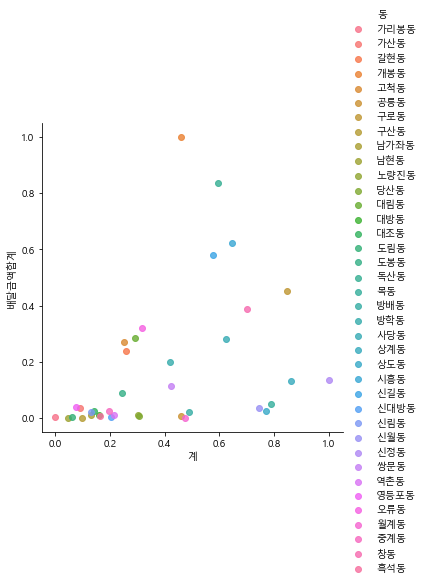

In [55]:
# 총가구수와 총주문금액을 동별로 분류
sns.lmplot('계','배달금액합계',data=df2,hue='동')

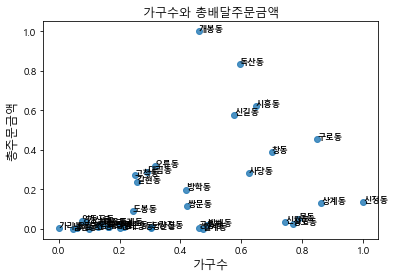

In [56]:
# 총가구수와 총주문금액을 k-means 분석으로 분류
p1=sns.regplot(x =df2['계'],y=df2['배달금액합계'],fit_reg=False)

for line in range(0,len(df2)):
     p1.text(df2["계"][line], df2["배달금액합계"][line],df2["동"][line], horizontalalignment='left', size='small', color='black', weight='semibold')
        
plt.xlabel('가구수', fontsize=12)
plt.ylabel('총주문금액', fontsize=12)
plt.title('가구수와 총배달주문금액', fontsize=12)
plt.show()

In [57]:
X = df2[['계','배달금액합계']]
X = pd.get_dummies(X)
kmeans=KMeans(n_clusters=3).fit(X)
df2['클러스터']=kmeans.labels_

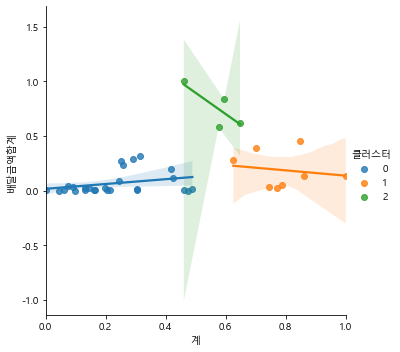

In [58]:
sns.lmplot('계','배달금액합계',data=df2,hue='클러스터')

## 3. 총 가구수와 배달 매출액 k-means 클러스터링(구별)

In [59]:
df1

,구,총주문금액,배달비용,접수시간,기간,총계,1인가구,2인가구,3인가구,4인가구,5인가구,6인가구,7인가구이상,평균가구원수,클러스터
0,관악구,0.066720,0.075690,438812,2019,1.000000,1.000000,55423,34875,24563,5806,1283,341,2,1
1,구로구,1.000000,1.000000,4933587,2019,0.427495,0.172996,43700,34624,26459,6214,1261,380,2.4,2
2,금천구,0.494999,0.503434,2350830,2019,0.000000,0.058766,25207,18771,13535,3131,708,185,2.2,0
3,노원구,0.043526,0.049879,269385,2019,0.715092,0.237496,52832,46783,38952,7772,1447,307,2.5,1
4,도봉구,0.288072,0.255711,1294096,2019,0.192636,0.000000,36329,29580,22061,4901,1014,293,2.5,0
5,동작구,0.110949,0.131114,642621,2019,0.459594,0.314585,40739,32514,24570,5564,1204,284,2.3,1
6,서대문구,0.000000,0.000487,39977,2019,0.205266,0.158193,32581,25283,18696,4376,976,274,2.3,1
7,서초구,0.000025,0.000000,40198,2019,0.392484,0.114826,38892,35327,29850,6704,1503,434,2.5,1
8,양천구,0.044311,0.042306,258893,2019,0.444921,0.042335,41435,40897,35189,7272,1393,336,2.6,1
9,영등포구,0.430733,0.435689,2005779,2019,0.382305,0.293097,38671,29661,21503,4597,1032,245,2.2,0


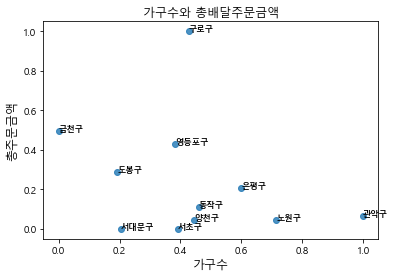

In [60]:
# 총가구수와 총주문금액을 구별로 분류
p1=sns.regplot(x =df1['총계'],y=df1['총주문금액'],fit_reg=False)

for line in range(0,len(df1)):
     p1.text(df1["총계"][line], df1["총주문금액"][line],df1["구"][line], horizontalalignment='left', size='small', color='black', weight='semibold')
        
plt.xlabel('가구수', fontsize=12)
plt.ylabel('총주문금액', fontsize=12)
plt.title('가구수와 총배달주문금액', fontsize=12)
plt.show()

In [61]:
X = df1[['총주문금액','총계']]
X = pd.get_dummies(X)
kmeans=KMeans(n_clusters=3).fit(X)
df1['클러스터']=kmeans.labels_

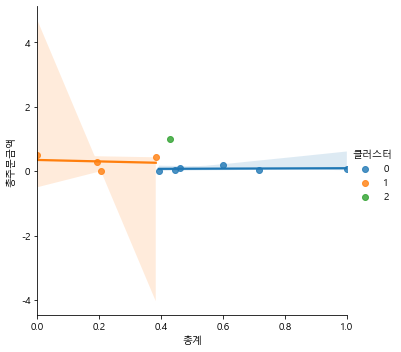

In [62]:
# 총가구수와 총주문금액을 k-means 분석으로 분류
sns.lmplot('총계','총주문금액',data=df1,hue='클러스터')

In [63]:
df1[df1['클러스터']==2] 

,구,총주문금액,배달비용,접수시간,기간,총계,1인가구,2인가구,3인가구,4인가구,5인가구,6인가구,7인가구이상,평균가구원수,클러스터
1,구로구,1.0,1.0,4933587,2019,0.427495,0.172996,43700,34624,26459,6214,1261,380,2.4,2


## 4. k-means 군집별 매출 많은 업종

In [65]:
grouped=delivery['금액'].groupby(delivery['구']).sum().reset_index()
#grouped.sort_index(ascending=True)
grouped.sort_values(by='금액',ascending=False)

,구,금액
1,구로구,6525882983
2,금천구,3252498354
9,영등포구,2835931485
4,도봉구,1911215011
10,은평구,1371731700
5,동작구,763113942
0,관악구,476420240
8,양천구,331169870
3,노원구,326081209
7,서초구,44110600


In [66]:
gu=pd.DataFrame(pd.pivot_table(delivery,index=['구','업종'],aggfunc=sum))
gu.to_csv("gu.csv",encoding="cp949")

In [67]:
gu1=gu.xs('구로구')

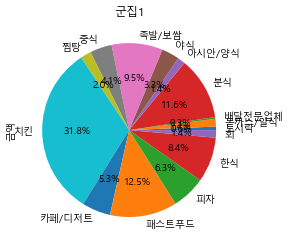

In [68]:
# k-means 1군집의 업종별 매출비율
gu1['금액'].plot.pie(autopct='%.1f%%')
plt.title('군집1')
plt.show()

In [69]:
gu2=pd.DataFrame(data={
"금액":[47920240,
196720700,
8133900,
1212872688,
390065607,
576094601,
1214283085,
241532400,
222336850,
1962445994,
189053160,
391600882,
630652055,
676906138,
82974700]},index=[
'도시락',
'돈까스/일식',
'배달전문업체',
'분식',
'아시안/양식',
'야식',
'족발/보쌈',
'중식',
'찜탕',
'치킨',
'카페/디저트',
'패스트푸드',
'피자',
'한식',
'회'   
],    )

gu2

,금액
도시락,47920240
돈까스/일식,196720700
배달전문업체,8133900
분식,1212872688
아시안/양식,390065607
야식,576094601
족발/보쌈,1214283085
중식,241532400
찜탕,222336850
치킨,1962445994


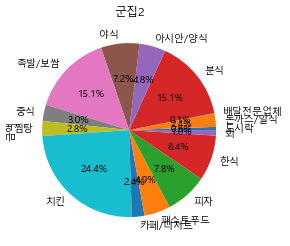

In [70]:
# k-means 2군집의 업종별 매출비율
gu2['금액'].plot.pie(autopct='%.1f%%',)
plt.title('군집2')
plt.show()

In [71]:
gu3=pd.DataFrame(data={
"금액":[5832600,
254019600,
199954900,
37327100,
47293500,
282724500,
8270000,
11778400,
615007502,
919404640,
423154020,
27774900,
187361299,
292724600

]},index=[
'도시락',
'돈까스/일식',
'분식',
'아시안/양식',
'야식',
'족발/보쌈',
'중식',
'찜탕',
'치킨',
'카페/디저트',
'패스트푸드',
'피자',
'한식',
'회'

],    )

gu3

,금액
도시락,5832600
돈까스/일식,254019600
분식,199954900
아시안/양식,37327100
야식,47293500
족발/보쌈,282724500
중식,8270000
찜탕,11778400
치킨,615007502
카페/디저트,919404640


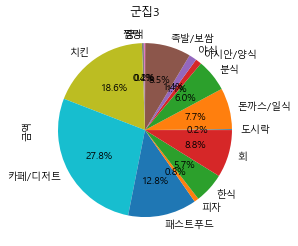

In [72]:
# k-means 3군집의 업종별 매출비율
gu3['금액'].plot.pie(autopct='%.1f%%',)
plt.title('군집3')
plt.show()

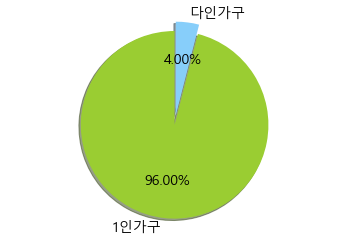

In [76]:
# 배달데이터 상 1인가구와 다인가구 비율

plt.pie(group_sizes, 

        explode=group_explodes, 

        labels=group_names, 

        colors=group_colors, 

        autopct='%1.2f%%', # second decimal place

        shadow=True, 

        startangle=90,

        textprops={'fontsize': 14}) # text font size

plt.axis('equal') #  equal length of X and Y axis

plt.title('', fontsize=20)

plt.show()



## 5. k-means 군집별 주문 업종 빈도

In [77]:
delivery

,처리일시,업종,구,동,목적지구,목적지동,금액,배달비용,접수시간,완료시간,시간대
0,2020-01-01,치킨,은평구,갈현동,은평구,갈현동,23000,3300,0,2020-01-01 00:18:47,야식
1,2020-01-01,분식,구로구,오류동,구로구,궁동,28000,3800,1,2020-01-01 01:41:45,야식
2,2020-01-01,치킨,영등포구,대림동,영등포구,신길동,17000,4800,0,2020-01-01 01:23:41,야식
3,2020-01-01,치킨,영등포구,신길동,영등포구,대림동,19000,3900,0,2020-01-01 00:42:53,야식
4,2020-01-01,치킨,금천구,독산동,관악구,신림동,21000,4300,1,2020-01-01 01:37:01,야식
...,...,...,...,...,...,...,...,...,...,...,...
791036,2020-06-21,회,은평구,갈현동,은평구,대조동,28000,3500,23,2020-06-21 23:46:17,야식
791037,2020-06-21,한식,구로구,고척동,구로구,고척동,18900,3300,23,2020-06-21 23:18:13,야식
791038,2020-06-21,배달전문업체,금천구,독산동,금천구,가산동,21900,3300,23,2020-06-21 23:48:26,야식
791039,2020-06-21,야식,도봉구,도봉동,노원구,상계동,22000,3600,22,2020-06-21 23:18:20,저녁


In [78]:
delivery_menu = pd.crosstab(delivery["구"], delivery["업종"]).reset_index()
delivery_menu

업종,구,도시락,돈까스/일식,배달전문업체,분식,아시안/양식,야식,족발/보쌈,중식,찜탕,치킨,카페/디저트,패스트푸드,피자,한식,회
0,관악구,0,0,0,0,0,0,42,0,58,1,21679,0,0,3983,0
1,구로구,1766,3845,822,39953,4240,6867,17990,11312,5276,91932,18636,44673,16729,23735,2347
2,금천구,0,1192,336,33738,4232,13813,18213,7313,1631,37378,4564,13050,0,3978,0
3,노원구,0,332,0,3607,925,108,0,0,0,922,8859,0,291,214,1069
4,도봉구,595,2338,0,8387,894,5939,9003,1175,1268,7804,1511,1597,22037,12827,1516
5,동작구,0,0,0,0,5,0,224,0,0,10466,11873,18822,618,209,0
6,서대문구,0,0,0,0,0,0,0,0,0,0,2692,0,0,0,0
7,서초구,0,0,0,4,0,0,0,0,0,0,0,2762,0,0,0
8,양천구,84,2948,0,531,0,1607,0,0,0,1500,7638,88,241,544,98
9,영등포구,1278,4899,0,18794,12000,3392,7358,1856,3933,47055,1709,7577,2812,10817,853


In [82]:
delivery_cafe=delivery_menu[['구','카페/디저트']]

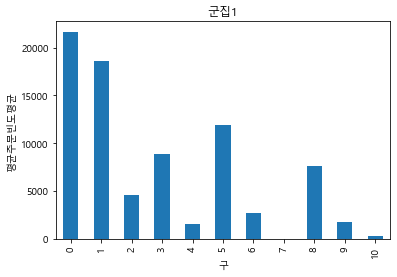

In [83]:
# k-means 1군집의 카페 주문 빈도

delivery_cafe['카페/디저트'].plot(kind='bar')
plt.title('군집1')
plt.xlabel("구")
plt.ylabel("평균주문빈도평균")
plt.show()

In [84]:
delivery_cafe=delivery_cafe.rename(columns={'금액':'카페매출금액'})
delivery_cafe

업종,구,카페/디저트
0,관악구,21679
1,구로구,18636
2,금천구,4564
3,노원구,8859
4,도봉구,1511
5,동작구,11873
6,서대문구,2692
7,서초구,0
8,양천구,7638
9,영등포구,1709


In [85]:
#배달 업종이 가장 많은 치킨을 기준으로 정렬

delivery_cafe = pd.DataFrame(delivery_cafe.sort_values(by=['카페/디저트'],inplace = False, ascending = False))
delivery_cafe

업종,구,카페/디저트
0,관악구,21679
1,구로구,18636
5,동작구,11873
3,노원구,8859
8,양천구,7638
2,금천구,4564
6,서대문구,2692
9,영등포구,1709
4,도봉구,1511
10,은평구,298


## 6. 업종별 매출이 높은 지역

In [94]:
# 카페 매출양이 높은 지역

In [95]:
cafe=delivery[delivery['업종']=='카페/디저트']

In [96]:
df_cafe=cafe.groupby(delivery['구']).sum().reset_index()

In [97]:
df_cafe

,구,금액,배달비용,접수시간
0,관악구,386715940,73684600,374329
1,구로구,346702680,65620650,294521
2,금천구,85179110,16294300,67563
3,노원구,162554450,32521600,149518
4,도봉구,28681400,5371100,22534
5,동작구,220289850,39421900,206341
6,서대문구,43948150,10013900,39977
7,양천구,144732400,25448200,131664
8,영등포구,31244500,6490081,27813
9,은평구,5112000,1136700,4580


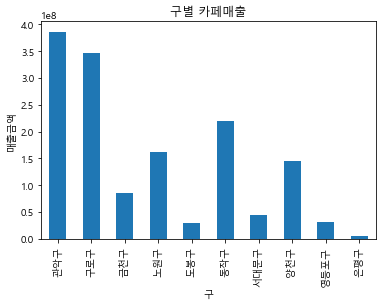

In [98]:

df_cafe['금액'].groupby(df_cafe['구']).sum().plot(kind='bar')
plt.title('구별 카페매출')
plt.xlabel("구")
plt.ylabel("매출금액")
plt.show()

In [99]:
df_cafe=df_cafe.rename(columns={'금액':'카페매출금액'})

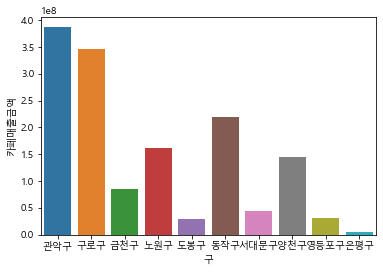

In [100]:
sns.barplot(
    data= df_cafe,
    x= "구",
    y= "카페매출금액")
 
plt.show()

In [101]:
# 카페을  시킨 가구가 많은 곳

In [102]:
cafe_gu=pd.merge(df_cafe,member_gu)
cafe_gu

,구,카페매출금액,배달비용,접수시간,기간,총계,1인가구,2인가구,3인가구,4인가구,5인가구,6인가구,7인가구이상,평균가구원수
0,관악구,386715940,73684600,374329,2019,242154,119863,55423,34875,24563,5806,1283,341,2
1,구로구,346702680,65620650,294521,2019,160378,47740,43700,34624,26459,6214,1261,380,2.4
2,금천구,85179110,16294300,67563,2019,99315,37778,25207,18771,13535,3131,708,185,2.2
3,노원구,162554450,32521600,149518,2019,201458,53365,52832,46783,38952,7772,1447,307,2.5
4,도봉구,28681400,5371100,22534,2019,126831,32653,36329,29580,22061,4901,1014,293,2.5
5,동작구,220289850,39421900,206341,2019,164963,60088,40739,32514,24570,5564,1204,284,2.3
6,서대문구,43948150,10013900,39977,2019,128635,46449,32581,25283,18696,4376,976,274,2.3
7,양천구,144732400,25448200,131664,2019,162867,36345,41435,40897,35189,7272,1393,336,2.6
8,영등포구,31244500,6490081,27813,2019,153923,58214,38671,29661,21503,4597,1032,245,2.2
9,은평구,5112000,1136700,4580,2019,184890,52814,52257,40789,29700,7303,1604,423,2.4


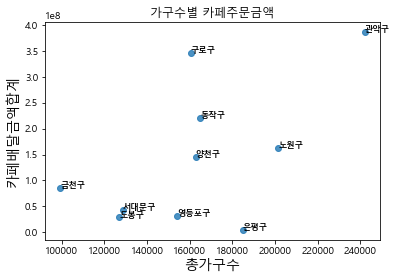

In [105]:
p1=sns.regplot(x =cafe_gu['총계'],y=cafe_gu['카페매출금액'],fit_reg=False)

for line in range(0,len(cafe_gu)):
     p1.text(cafe_gu["총계"][line], cafe_gu["카페매출금액"][line],cafe_gu["구"][line], horizontalalignment='left', size='small', color='black', weight='semibold')
        
plt.xlabel('총가구수', fontsize=14)
plt.ylabel('카페배달금액합계', fontsize=14)
plt.title('가구수별 카페주문금액')
plt.show()

In [107]:
# 분식 매출양이 높은 지역

In [108]:
bs=delivery[delivery['업종']=='분식']

In [109]:
bs

,처리일시,업종,구,동,목적지구,목적지동,금액,배달비용,접수시간,완료시간,시간대
1,2020-01-01,분식,구로구,오류동,구로구,궁동,28000,3800,1,2020-01-01 01:41:45,야식
55,2020-01-01,분식,노원구,상계동,노원구,상계동,17000,4000,0,2020-01-01 01:15:56,야식
75,2020-01-01,분식,노원구,상계동,노원구,상계동,18000,3000,0,2020-01-01 00:50:41,야식
77,2020-01-01,분식,노원구,상계동,노원구,상계동,16500,3300,0,2020-01-01 01:15:49,야식
97,2020-01-01,분식,노원구,상계동,노원구,중계동,22500,4000,0,2020-01-01 00:55:36,야식
...,...,...,...,...,...,...,...,...,...,...,...
790992,2020-06-21,분식,금천구,독산동,금천구,독산동,15900,3300,23,2020-06-21 23:44:53,야식
791001,2020-06-21,분식,구로구,오류동,구로구,개봉동,21000,3630,22,2020-06-21 23:10:11,저녁
791003,2020-06-21,분식,구로구,오류동,구로구,개봉동,18500,3740,23,2020-06-21 23:31:55,야식
791009,2020-06-21,분식,구로구,오류동,구로구,오류동,15500,3630,23,2020-06-21 23:36:13,야식


In [110]:
df_bs=bs.groupby(bs['구']).sum().reset_index()
df_bs

,구,금액,배달비용,접수시간
0,구로구,758818205,147760590,646514
1,금천구,678682884,127993290,562276
2,노원구,75125500,14719040,56751
3,도봉구,165680900,30567900,132034
4,서초구,84400,17050,69
5,양천구,11071300,1840100,7980
6,영등포구,368508904,65319400,286366
7,은평구,113673700,20663700,91529


In [111]:
df_bs=df_bs.rename(columns={'금액':'분식매출금액'})

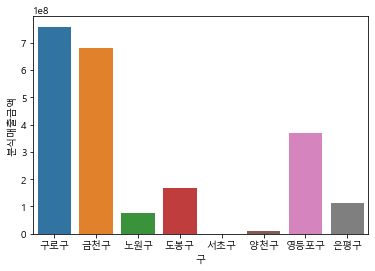

In [112]:
sns.barplot(
    data= df_bs,
    x= "구",
    y= "분식매출금액")
 
plt.show()

In [113]:
bs_gu=pd.merge(df_bs,member_gu)
bs_gu

,구,분식매출금액,배달비용,접수시간,기간,총계,1인가구,2인가구,3인가구,4인가구,5인가구,6인가구,7인가구이상,평균가구원수
0,구로구,758818205,147760590,646514,2019,160378,47740,43700,34624,26459,6214,1261,380,2.4
1,금천구,678682884,127993290,562276,2019,99315,37778,25207,18771,13535,3131,708,185,2.2
2,노원구,75125500,14719040,56751,2019,201458,53365,52832,46783,38952,7772,1447,307,2.5
3,도봉구,165680900,30567900,132034,2019,126831,32653,36329,29580,22061,4901,1014,293,2.5
4,서초구,84400,17050,69,2019,155377,42667,38892,35327,29850,6704,1503,434,2.5
5,양천구,11071300,1840100,7980,2019,162867,36345,41435,40897,35189,7272,1393,336,2.6
6,영등포구,368508904,65319400,286366,2019,153923,58214,38671,29661,21503,4597,1032,245,2.2
7,은평구,113673700,20663700,91529,2019,184890,52814,52257,40789,29700,7303,1604,423,2.4


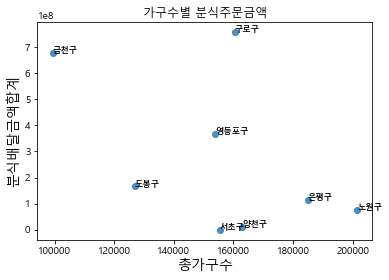

In [114]:
p1=sns.regplot(x =bs_gu['총계'],y=bs_gu['분식매출금액'],fit_reg=False)

for line in range(0,len(bs_gu)):
     p1.text(bs_gu["총계"][line], bs_gu["분식매출금액"][line],bs_gu["구"][line], horizontalalignment='left', size='small', color='black', weight='semibold')
        
plt.xlabel('총가구수', fontsize=14)
plt.ylabel('분식배달금액합계', fontsize=14)
plt.title('가구수별 분식주문금액')
plt.show()

In [115]:
# 치킨 매출양이 높은 지역

In [118]:
delivery[delivery['업종']=='치킨']

,처리일시,업종,구,동,목적지구,목적지동,금액,배달비용,접수시간,완료시간,시간대
0,2020-01-01,치킨,은평구,갈현동,은평구,갈현동,23000,3300,0,2020-01-01 00:18:47,야식
2,2020-01-01,치킨,영등포구,대림동,영등포구,신길동,17000,4800,0,2020-01-01 01:23:41,야식
3,2020-01-01,치킨,영등포구,신길동,영등포구,대림동,19000,3900,0,2020-01-01 00:42:53,야식
4,2020-01-01,치킨,금천구,독산동,관악구,신림동,21000,4300,1,2020-01-01 01:37:01,야식
7,2020-01-01,치킨,금천구,독산동,금천구,시흥동,41500,4800,1,2020-01-01 01:39:57,야식
...,...,...,...,...,...,...,...,...,...,...,...
791020,2020-06-21,치킨,영등포구,대림동,관악구,신림동,15000,3630,23,2020-06-22 00:11:30,야식
791023,2020-06-21,치킨,양천구,신월동,양천구,신월동,22500,3500,23,2020-06-21 23:59:26,야식
791024,2020-06-21,치킨,구로구,개봉동,구로구,오류동,27000,3630,23,2020-06-21 23:46:45,야식
791032,2020-06-21,치킨,구로구,고척동,구로구,고척동,20400,3300,22,2020-06-21 23:05:57,저녁


In [119]:
ch=delivery[delivery['업종']=='치킨']

In [120]:
df_ch=ch.groupby(delivery['구']).sum().reset_index()
df_ch

,구,금액,배달비용,접수시간
0,관악구,33000,3000,22
1,구로구,2078129397,339598830,1681912
2,금천구,818222253,148588290,632421
3,노원구,19669000,3305700,14180
4,도봉구,157336700,27239300,139645
5,동작구,232164002,39587480,177937
6,양천구,31166000,5806800,26661
7,영등포구,986887041,180214962,794370
8,은평구,331975500,64714930,317047


In [121]:
bs_ch=pd.merge(df_ch,member_gu)
bs_ch

,구,금액,배달비용,접수시간,기간,총계,1인가구,2인가구,3인가구,4인가구,5인가구,6인가구,7인가구이상,평균가구원수
0,관악구,33000,3000,22,2019,242154,119863,55423,34875,24563,5806,1283,341,2
1,구로구,2078129397,339598830,1681912,2019,160378,47740,43700,34624,26459,6214,1261,380,2.4
2,금천구,818222253,148588290,632421,2019,99315,37778,25207,18771,13535,3131,708,185,2.2
3,노원구,19669000,3305700,14180,2019,201458,53365,52832,46783,38952,7772,1447,307,2.5
4,도봉구,157336700,27239300,139645,2019,126831,32653,36329,29580,22061,4901,1014,293,2.5
5,동작구,232164002,39587480,177937,2019,164963,60088,40739,32514,24570,5564,1204,284,2.3
6,양천구,31166000,5806800,26661,2019,162867,36345,41435,40897,35189,7272,1393,336,2.6
7,영등포구,986887041,180214962,794370,2019,153923,58214,38671,29661,21503,4597,1032,245,2.2
8,은평구,331975500,64714930,317047,2019,184890,52814,52257,40789,29700,7303,1604,423,2.4


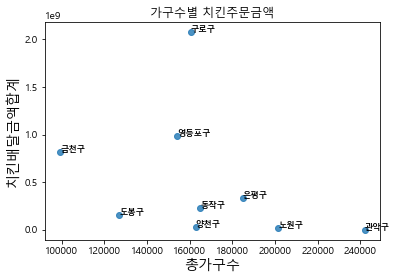

In [122]:
p1=sns.regplot(x =bs_ch['총계'],y=bs_ch['금액'],fit_reg=False)

for line in range(0,len(bs_ch)):
     p1.text(bs_ch["총계"][line], bs_ch["금액"][line],bs_ch["구"][line], horizontalalignment='left', size='small', color='black', weight='semibold')

plt.xlabel('총가구수', fontsize=14)
plt.ylabel('치킨배달금액합계', fontsize=14)
plt.title('가구수별 치킨주문금액')
plt.show()

## 서울시내 카페업체수

In [124]:
seoul_cafe=pd.read_csv("cafe.csv",encoding='cp949',header=None)
seoul_cafe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       25 non-null     object
 1   1       25 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 528.0+ bytes


In [125]:
seoul_cafe[0]=seoul_cafe[0].map(lambda x:x.replace('?',''))

In [126]:
seoul_cafe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       25 non-null     object
 1   1       25 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 528.0+ bytes


In [127]:
seoul_cafe=seoul_cafe.rename(columns={0:'구',1:'개수',})

In [128]:
c=pd.merge(seoul_cafe,cafe_gu,how='inner')

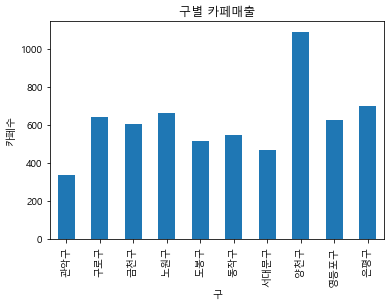

In [129]:
c['개수'].groupby(df_cafe['구']).sum().plot(kind='bar')
plt.title('구별 카페매출')
plt.xlabel("구")
plt.ylabel("카페수")
plt.show()

In [130]:
c=c.rename(columns={'개수':'카페매장수'})

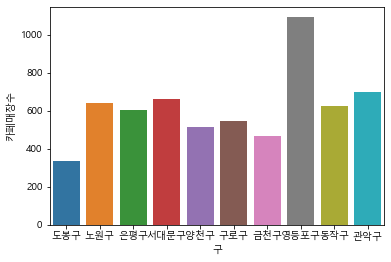

In [131]:

sns.barplot(
    data= c,
    x= "구",
    y= "카페매장수")
 
plt.show()

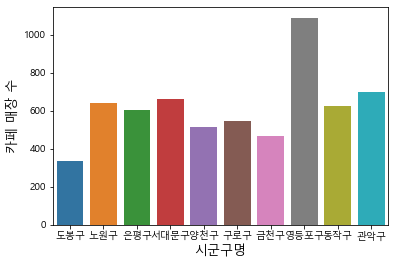

In [132]:
sns.barplot(
    data= c,
    x= "구",
    y= "카페매장수")
 
plt.ylabel('카페 매장 수', fontsize=13)
plt.xlabel('시군구명', fontsize=13)
plt.show()